# **ABT 182 - Lab 5 Demo: GeoPandas with USA Data**

## **Same structure as Lab 5 (California counties), but using USA states**

This demo shows:
- Reading a shapefile (USA states)
- Reprojecting, computing area, summary statistics
- Querying (largest/smallest), basic plots and choropleths
- Attribute join with a CSV (e.g. state-level food insecurity, population, or other indicators)
- A simple plotting function for mapped variables by year

**Data:** All in `Week5/Demo/Data/`: USA states shapefile (`tl_2024_us_state/`) and state population CSV (`US_state_data.csv` — State, Year, Population). See `Data/DATA_SOURCES.md` for sources.

**Images** from this notebook are saved to `Demo/Images/` for use on the course website.

In [28]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Paths: run from Week5/Demo; data lives in Data/ (shapefile + US_state_data.csv)
DATA_DIR = os.path.join(os.getcwd(), 'Data')
IMAGES_DIR = os.path.join(os.getcwd(), 'Images')
os.makedirs(IMAGES_DIR, exist_ok=True)

# Final data (Week5/Demo/Data): TIGER 2024 states shapefile + state population CSV
SHP_PATH = os.path.join(DATA_DIR, 'tl_2024_us_state', 'tl_2024_us_state.shp')
CSV_PATH = os.path.join(DATA_DIR, 'US_state_data.csv')

print('Data dir:', DATA_DIR)
print('Images dir:', IMAGES_DIR)
print('Shapefile exists:', os.path.exists(SHP_PATH))
print('CSV exists:', os.path.exists(CSV_PATH))

Data dir: c:\mnarimani\1-UCDavis\9-Github\ABT182_Advance_GIS_UCDavis\code\colab\Week5\Demo\Data
Images dir: c:\mnarimani\1-UCDavis\9-Github\ABT182_Advance_GIS_UCDavis\code\colab\Week5\Demo\Images
Shapefile exists: True
CSV exists: True


## Step 1: Read USA states shapefile and explore

Same ideas as Lab 5 Exercise 1: read shapefile, then head, shape, columns, info, CRS.

In [29]:
states = gpd.read_file(SHP_PATH)
print(states.head())
print('\nShape:', states.shape)
print('Columns:', list(states.columns))
print('\nCRS:', states.crs)

  REGION DIVISION STATEFP   STATENS GEOID      GEOIDFQ STUSPS           NAME  \
0      3        5      54  01779805    54  0400000US54     WV  West Virginia   
1      3        5      12  00294478    12  0400000US12     FL        Florida   
2      2        3      17  01779784    17  0400000US17     IL       Illinois   
3      2        4      27  00662849    27  0400000US27     MN      Minnesota   
4      3        5      24  01714934    24  0400000US24     MD       Maryland   

  LSAD  MTFCC FUNCSTAT         ALAND       AWATER     INTPTLAT      INTPTLON  \
0   00  G4000        A   62266513826    488918898  +38.6472854  -080.6183274   
1   00  G4000        A  138965379385  45968913048  +28.3989775  -082.5143005   
2   00  G4000        A  143778206717   6216848695  +40.1028754  -089.1526108   
3   00  G4000        A  206244791203  18937236061  +46.3159573  -094.1996043   
4   00  G4000        A   25151223822   6979843236  +38.9466584  -076.6744939   

                                      

## Step 2: Reproject and add area (km²)

Use a US projection (e.g. Albers Equal Area for USA, EPSG:5070), then compute area in km².

In [30]:
gdf = states.to_crs(5070)
gdf['area'] = gdf.geometry.area / 1_000_000
print(gdf[['NAME', 'area']].head(10))

             NAME           area
0   West Virginia   62755.438109
1         Florida  184934.309000
2        Illinois  149995.054520
3       Minnesota  225182.049911
4        Maryland   32131.069585
5    Rhode Island    4001.454713
6           Idaho  216441.518208
7   New Hampshire   24216.084673
8  North Carolina  139389.430056
9         Vermont   24903.239355


### Filter to contiguous US (main map only)

Alaska, Hawaii, Puerto Rico, and other territories are far from the lower 48 and distort the map. For the demo we keep only the **contiguous United States + DC** so the main map of America is clear.

In [31]:
# Exclude states/territories not in the contiguous US (Alaska, Hawaii, Puerto Rico, territories)
EXCLUDE_STUSPS = ['AK', 'HI', 'PR', 'GU', 'VI', 'AS', 'MP']  # Alaska, Hawaii, PR, Guam, USVI, American Samoa, N. Mariana Is.
gdf = gdf[~gdf['STUSPS'].isin(EXCLUDE_STUSPS)].copy()
print(f'Kept {len(gdf)} states (contiguous US + DC). Excluded: {EXCLUDE_STUSPS}')
print(gdf[['NAME', 'area']].head())

Kept 49 states (contiguous US + DC). Excluded: ['AK', 'HI', 'PR', 'GU', 'VI', 'AS', 'MP']
            NAME           area
0  West Virginia   62755.438109
1        Florida  184934.309000
2       Illinois  149995.054520
3      Minnesota  225182.049911
4       Maryland   32131.069585


## Step 3: Summary statistics and largest/smallest state

In [32]:
stats = gdf['area'].agg(['sum', 'mean', 'max', 'min', 'std'])
for k, v in stats.items():
    print(f'{k}: {v}')
idx_max = gdf['area'].idxmax()
idx_min = gdf['area'].idxmin()
name_col = 'NAME' if 'NAME' in gdf.columns else gdf.columns[gdf.columns.str.contains('name', case=False)][0]
print(f"\nLargest: {gdf.loc[idx_max, name_col]} ({gdf.loc[idx_max, 'area']:.2f} km²)")
print(f"Smallest: {gdf.loc[idx_min, name_col]} ({gdf.loc[idx_min, 'area']:.2f} km²)")

sum: 8096533.712561682
mean: 165235.38188901392
max: 695668.3537992389
min: 177.02595526618632
std: 124514.25756104257

Largest: Texas (695668.35 km²)
Smallest: District of Columbia (177.03 km²)


## Step 4: Basic map and choropleth by area (save images)

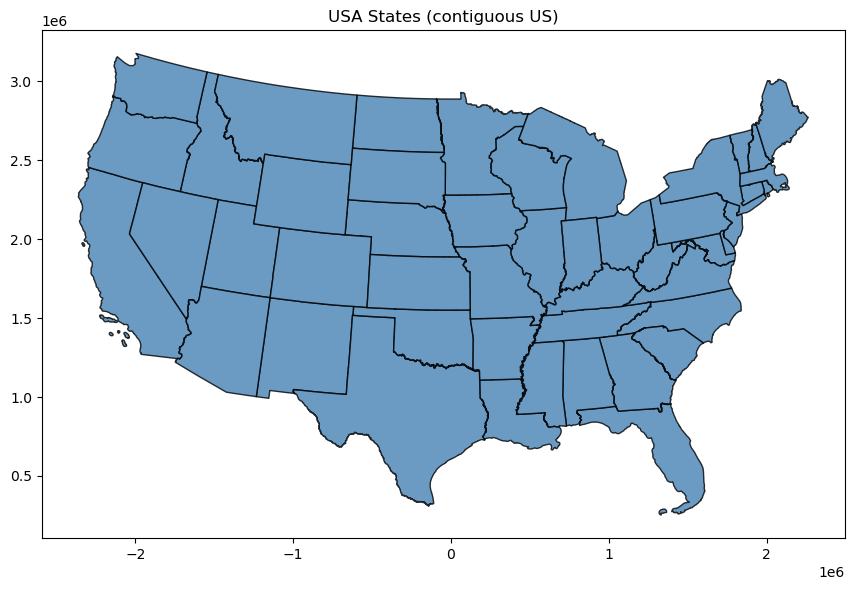

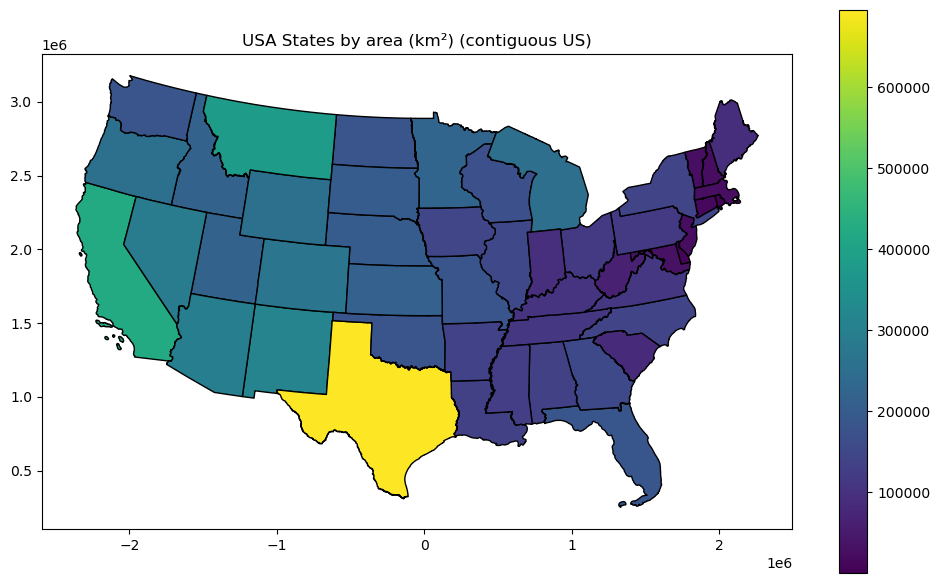

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gdf.plot(ax=ax, alpha=0.8, color='steelblue', edgecolor='k')
ax.set_title('USA States (contiguous US)')
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'Step1_StatesMap.png'), dpi=150, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gdf.plot(ax=ax, column='area', cmap='viridis', legend=True, edgecolor='k')
ax.set_title('USA States by area (km²) (contiguous US)')
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'Step2_AreaChoropleth.png'), dpi=150, bbox_inches='tight')
plt.show()

## Step 5: Choropleth with classification (mapclassify)

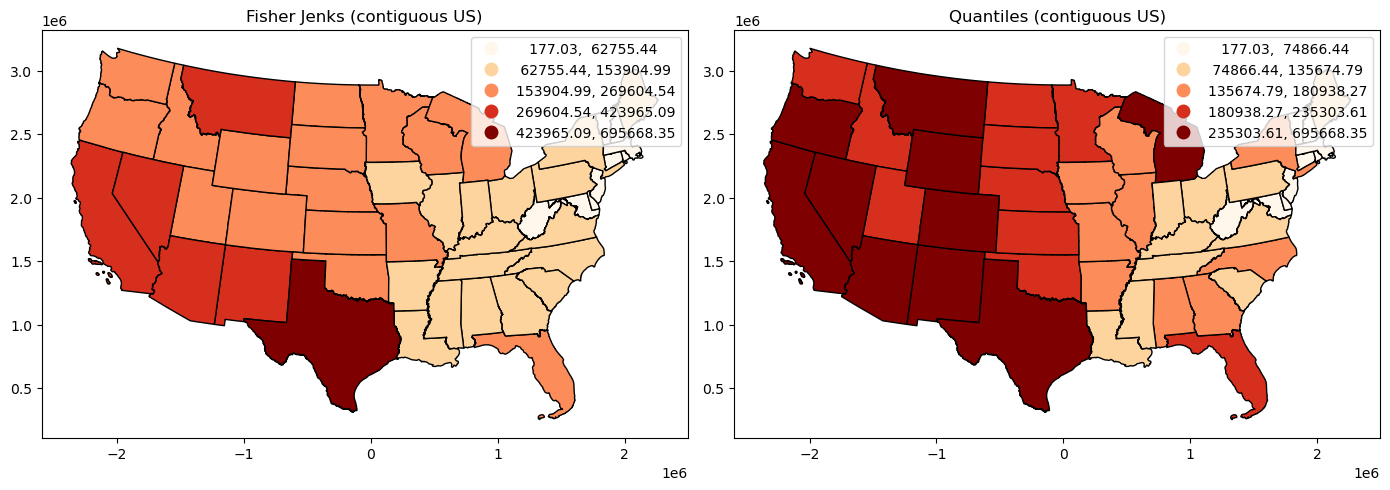

In [34]:
try:
    import mapclassify
except ImportError:
    import subprocess; subprocess.check_call(['pip', 'install', 'mapclassify'])
    import mapclassify

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
gdf.plot(ax=axes[0], column='area', cmap='OrRd', legend=True, edgecolor='k', scheme='fisher_jenks')
axes[0].set_title('Fisher Jenks (contiguous US)')
gdf.plot(ax=axes[1], column='area', cmap='OrRd', legend=True, edgecolor='k', scheme='quantiles')
axes[1].set_title('Quantiles (contiguous US)')
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'Step3_AreaSchemes.png'), dpi=150, bbox_inches='tight')
plt.show()

## Step 6: Read CSV and merge (attribute join)

CSV must have a state name column matching the shapefile (e.g. `NAME` or `State`). Clean names if needed, then merge.

In [35]:
df = pd.read_csv(CSV_PATH)
print(df.head())
print('Columns:', list(df.columns))
# If CSV uses 'State' and shapefile uses 'NAME', create a common key
name_col_gdf = 'NAME' if 'NAME' in gdf.columns else [c for c in gdf.columns if 'name' in c.lower()][0]
if 'State' in df.columns and name_col_gdf not in df.columns:
    df = df.rename(columns={'State': name_col_gdf})
merged_gdf = gdf.merge(df, on=name_col_gdf, how='inner')
print('\nMerged shape:', merged_gdf.shape)

     State  Year  Population
0  Alabama  2020     5032962
1  Alabama  2021     5050058
2  Alabama  2022     5076868
3  Alabama  2023     5117850
4  Alabama  2024     5163055
Columns: ['State', 'Year', 'Population']

Merged shape: (294, 19)


## Step 7: Query function and choropleth by variable/year (save images)

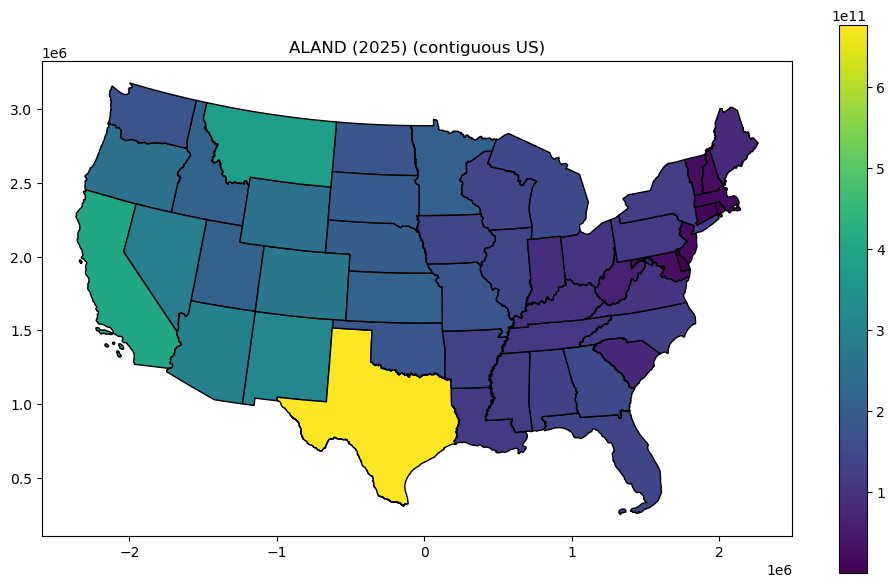

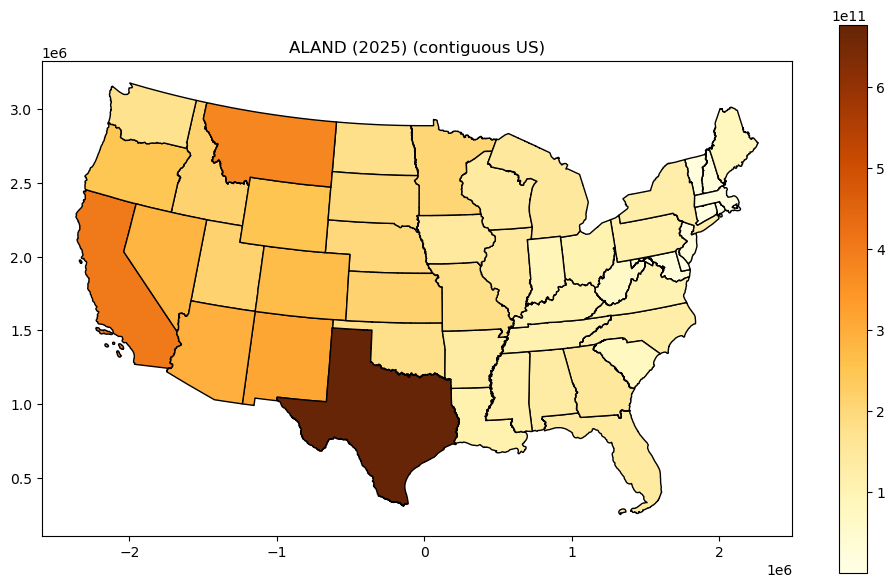

In [36]:
def gdf_plot(gdf, column, year, cmap, savepath=None):
    gdf_year = gdf[gdf['Year'] == year].copy()
    if gdf_year.empty:
        print(f'No data for year {year}')
        return
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    gdf_year.plot(ax=ax, column=column, cmap=cmap, legend=True, edgecolor='k')
    ax.set_title(f'{column} ({year}) (contiguous US)')
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()

year_col = [c for c in merged_gdf.columns if 'year' in c.lower() or c == 'Year']
year_col = year_col[0] if year_col else 'Year'
# Use first numeric column from the CSV for the choropleth (e.g. Food Insecurity, Population); skip 'area'
num_cols = [c for c in merged_gdf.select_dtypes(include=[np.number]).columns if c != 'area']
col_var = num_cols[0] if num_cols else merged_gdf.select_dtypes(include=[np.number]).columns[0]
years = merged_gdf[year_col].dropna().unique()
sample_year = int(years.max()) if len(years) else 2019

gdf_plot(merged_gdf, col_var, sample_year, 'viridis', os.path.join(IMAGES_DIR, 'Step4_Variable_Year.png'))
gdf_plot(merged_gdf, col_var, sample_year, 'YlOrBr', os.path.join(IMAGES_DIR, 'Step5_Variable_YlOrBr.png'))